## 空间滤波

- 将之前进行空间滤波的代码进行了完善，添加了低通和高通的滤波功能

- 将整体滤波函数进行了封装


这里使用的测试数据是：
- olr

数据获取地址为：
- https://psl.noaa.gov/thredds/catalog/Datasets/interp_OLR/catalog.html


同时，与matlab中的空间滤波函数进行了对比，整体上的特征是一致的，数值上存在些许区别

0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11


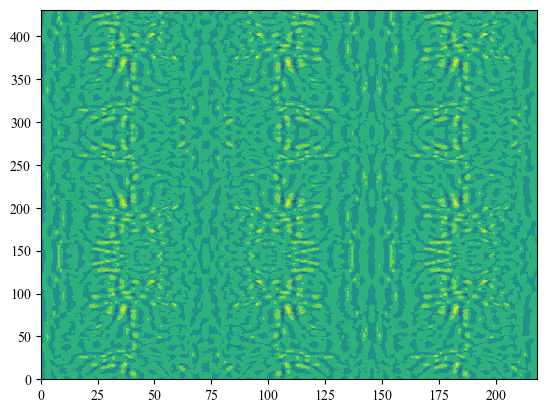

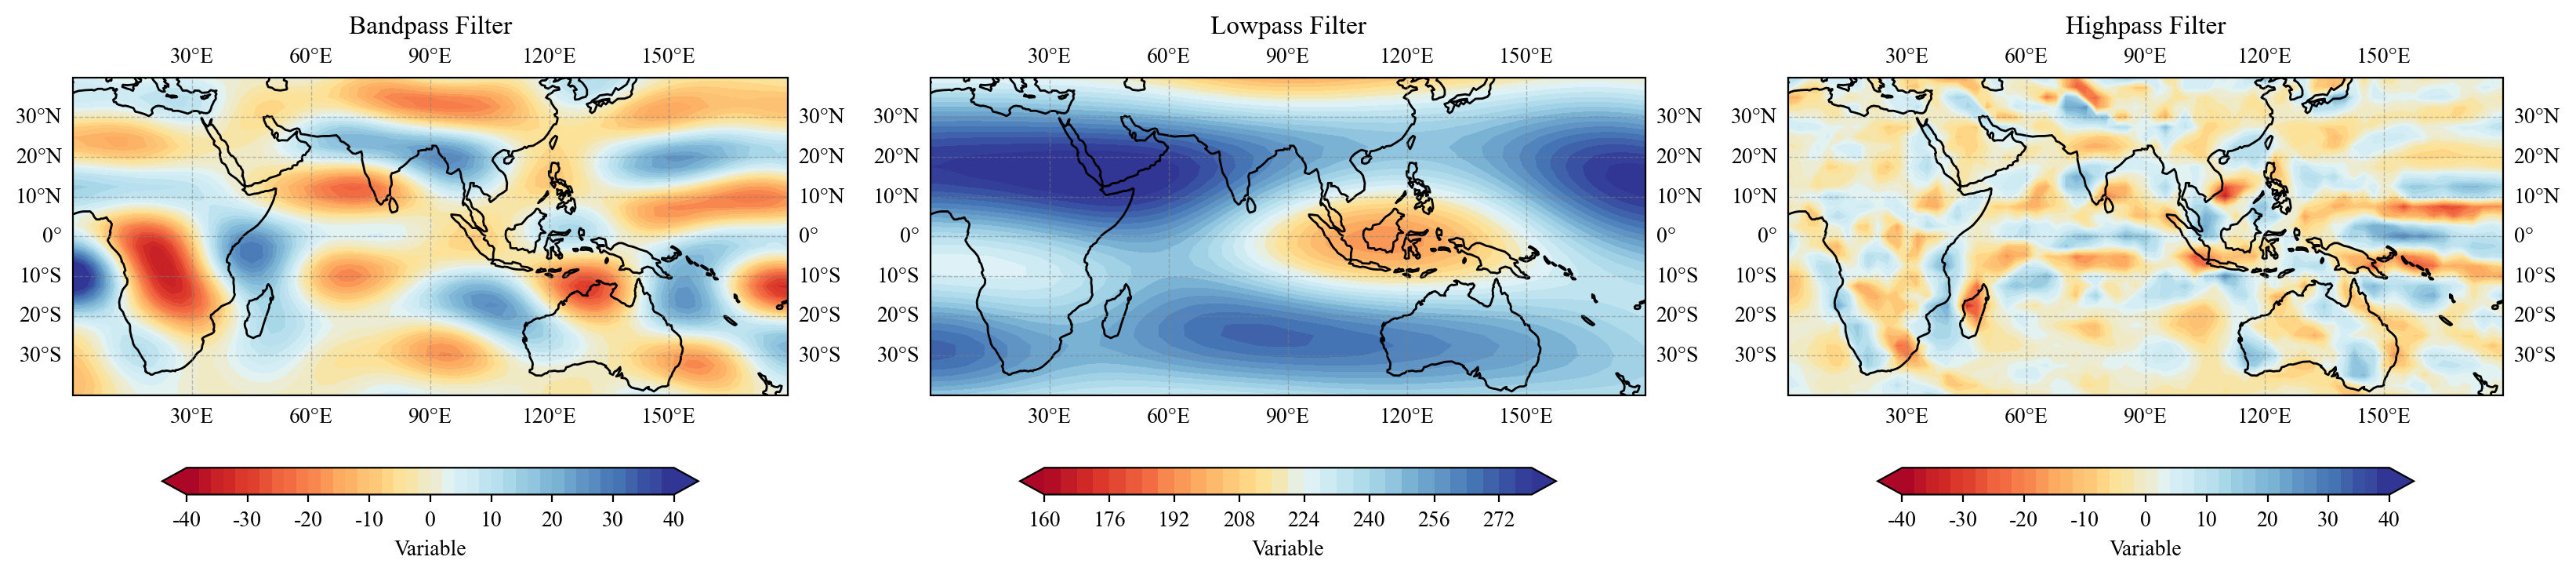

In [5]:
# -*- coding: utf-8 -*-
"""
Created on 2024-04-25

@author: %(Jianpu)s

Email: Xianpu_JI2024@outlook.com

Introduction: keep learning although walk slowly
"""

import os
import xarray as xr
import glob
import numpy as np
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.optimize import curve_fit
from typing import Tuple

class SpatialFilter:
    def __init__(self, data: xr.DataArray, lat: np.ndarray, lon: np.ndarray):
        """
        初始化空间滤波类。

        参数：
            data: xarray.DataArray，包含时间、纬度和经度维度的数据。
            lat: numpy.ndarray，纬度坐标。
            lon: numpy.ndarray，经度坐标。
        """
        self.data = data
        self.lat = lat
        self.lon = lon

    def vars_expend(self, var: np.ndarray) -> np.ndarray:
        """
        将二维变量进行扩展，通过在顶部、底部、左侧和右侧添加行和列来实现。

        参数：
            var: numpy.ndarray，要扩展的二维数组。

        返回：
            uall: numpy.ndarray，扩展后的变量。
        """
        M, N = var.shape
        ull = np.zeros_like(var)
        for i in range(N):
            ull[:, N-i-1] = var[:, i]
        umid = np.hstack((ull, var))
        umid = np.hstack((umid, ull))
        uupper = np.zeros_like(umid)
        for i in range(M):
            uupper[M-i-1, :] = umid[i, :]
        uall = np.vstack((uupper, umid))
        uall = np.vstack((uall, uupper))
        return uall

    def SBandpass2(self, var: np.ndarray, Up: float, Dw: float, filter: str = "") -> np.ndarray:
        """
        对二维变量进行带通、低通和高通滤波操作。

        参数：
            var: numpy.ndarray，要滤波的二维数组。
            Up: float，频率的上限。
            Dw: float，频率的下限。
            filter: str，选择滤波类型（'band'、'low'、'high'）。

        返回：
            varf: numpy.ndarray，滤波后的变量。
        """
        dx, dy = self.dxdy(self.lon, self.lat)
        dx = np.mean(dx) / 1000
        dy = np.mean(dy) / 1000

        var = self.Sxy2d_fitnan(var, self.lon, self.lat)
        var0 = var
        var = self.vars_expend(var).T
        plt.contourf(var)
        M, N = var.shape
        dkx = 1 / (M - 1) / dx
        dky = 1 / (N - 1) / dy

        var[np.isnan(var)] = 0

        h1 = np.ones((M, N))
        F2 = fft2(var)
        F2 = fftshift(F2)

        for i in range(M):
            for j in range(N):
                dist = np.sqrt(((i - (M + 1) / 2) * dkx) ** 2 + ((j - (N + 1) / 2) * dky) ** 2)

                # 根据滤波类型进行相应操作
                if filter == 'band':
                    # 带通滤波：保留 Dw 和 Up 之间的频率
                    if dist > 1 / Dw or dist < 1 / Up:
                        h1[i, j] = 0
                elif filter == 'low':
                    # 低通滤波：保留低于 Up 的频率
                    if dist > 1 / Up:
                        h1[i, j] = 0
                elif filter == 'high':
                    # 高通滤波：保留高于 Dw 的频率
                    if dist < 1 / Dw:
                        h1[i, j] = 0

        G2 = F2 * h1
        G2 = ifftshift(G2)
        varf = np.real(ifft2(G2))
        plt.contourf(varf)

        # 修正 varf 大小
        M, N = var0.T.shape
        varf = varf[M:2*M, N:2*N]

        return varf

    def Sxy2d_fitnan(self, data: np.ndarray, lon: np.ndarray, lat: np.ndarray) -> np.ndarray:
        """
        对具有 NaN 值的二维数据进行插值处理。

        参数：
            data: numpy.ndarray，包含 NaN 值的二维数组。
            lon: numpy.ndarray，数据的经度坐标。
            lat: numpy.ndarray，数据的纬度坐标。

        返回：
            datanew: numpy.ndarray，填充 NaN 值后的数据。
        """
        lon2d, lat2d = np.meshgrid(lon, lat)
        isnan = np.isnan(data)

        # 将二维坐标和数据中的非 NaN 值提取出来
        xy_valid = np.column_stack((lon2d[~isnan], lat2d[~isnan]))
        data = np.array(data)
        data_valid = data[~isnan]

        # 定义拟合函数
        def fc(xy, *c):
            return c[0] + c[1]*xy[:,0] + c[2]*xy[:,1] + c[3]*xy[:,0]*xy[:,0] + c[4]*xy[:,1]*xy[:,1] + c[5]*xy[:,0]*xy[:,1]

        lb = None
        ub = None

        initial_guess = [1.0, 1.0, 1.0, 1.0, 2.0, 2.0]

        # 使用 curve_fit 进行拟合
        c, _ = curve_fit(fc, xy_valid, data_valid, p0=initial_guess, bounds=(lb, ub))

        # 使用拟合参数填补 NaN 值
        data_fit = c[0] + c[1]*lon2d + c[2]*lat2d + c[3]*lon2d*lon2d + c[4]*lat2d*lat2d + c[5]*lon2d*lat2d

        # 将填补后的数据与原始数据合并，仅保留原始数据中的 NaN 值位置填补后的数据
        datanew = np.where(isnan, data_fit, data)

        return datanew

    def dxdy(self, lon: np.ndarray, lat: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        根据纬度和经度坐标计算 x 和 y 方向上的网格间距。

        参数：
            lat: numpy.ndarray，纬度坐标。
            lon: numpy.ndarray，经度坐标。

        返回：
            dx: numpy.ndarray，x 方向上的网格间距。
            dy: numpy.ndarray，y 方向上的网格间距。
        """
        xlon, ylat = np.meshgrid(lon, lat)
        dlony, dlonx = np.gradient(xlon)
        dlaty, dlatx = np.gradient(ylat)
        pi = 3.14159265
        re = 6.37e6
        dx = re * np.cos(ylat * pi / 180) * dlonx * pi / 180
        dy = re * dlaty * pi / 180

        return dx, dy

    def plot(self, ax: plt.Axes, title: str, varf: np.ndarray, lon: np.ndarray, lat: np.ndarray, levels: np.ndarray) -> Tuple[plt.Axes, plt.contour]:
        """
        绘制函数。

        参数：
            ax: matplotlib.axes._subplots.AxesSubplot，子图对象。
            title: str，图像标题。
            varf: numpy.ndarray，要绘制的数据。
            lon: numpy.ndarray，经度坐标。
            lat: numpy.ndarray，纬度坐标。
            levels: numpy.ndarray，等高线的级别。

        返回：
            ax: matplotlib.axes._subplots.AxesSubplot，子图对象。
            contour: matplotlib.contour.QuadContourSet，等高线对象。
        """
        contour = ax.contourf(lon, lat, varf.T, cmap=cmaps.cmp_b2r[::-1], levels=levels, extend='both')
        ax.add_feature(cfeature.COASTLINE)
        ax.set_extent([0, 180, -40, 40], crs=ccrs.PlateCarree())
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_left = False
        ax.set_title(title)
        return ax, contour

    def filter_data(self, Up: float, Dw: float, filter: str = None) -> xr.DataArray:
        """
        对数据进行滤波处理。

        参数：
            Up: float，频率的上限。
            Dw: float，频率的下限。
            filter: str，选择滤波类型（'band'、'low'、'high'）。

        返回：
            filtered_data: xarray.DataArray，滤波后的数据。
        """
        x = np.full((self.data.shape[0], self.data.shape[2], self.data.shape[1]), np.nan)
        # x.shape(time,lat,lon)
        for i in range(x.shape[0]):
            print(i)
            x[i, :, :] = self.SBandpass2(self.data[i], Up=Up, Dw=Dw, filter=filter)
            
        filtered_data = xr.DataArray(
            x,
            dims=["time", "lon", "lat"],
            coords=self.data.coords,
            attrs=self.data.attrs
        )

        return filtered_data

# 读取数据
data = xr.open_dataset(r'M:\old_desktop\any\daily\jxp\olr.mon.mean.nc').olr.sel(time=slice('2020', '2021'))
lon, lat = data.lon, data.lat

# 创建空间滤波对象
spatial_filter = SpatialFilter(data, lat.values, lon.values)

# 定义滤波参数
Up = 4000
Dw = 2000

# 进行不同滤波处理
varf_band = spatial_filter.filter_data(Up=Up, Dw=Dw, filter='band')
varf_low = spatial_filter.filter_data(Up=Up, Dw=Dw, filter='low')
varf_high = spatial_filter.filter_data(Up=Up, Dw=Dw, filter='high')

# 创建图像
fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=200, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# 绘制带通滤波结果
ax0, contour0 = spatial_filter.plot(axes[0], 'Bandpass Filter', varf_band[-1], lon, lat, levels=np.linspace(-40, 40, 41))

# 绘制低通滤波结果
ax1, contour1 = spatial_filter.plot(axes[1], 'Lowpass Filter', varf_low[-1], lon, lat, levels=np.linspace(160, 280, 31))

# 绘制高通滤波结果
ax2, contour2 = spatial_filter.plot(axes[2], 'Highpass Filter', varf_high[-1], lon, lat, levels=np.linspace(-40, 40, 41))

# 为所有子图添加一个统一的色标
fig.colorbar(contour0, ax=axes[0], pad=0.1, orientation='horizontal', shrink=0.75, label='Variable')
fig.colorbar(contour1, ax=axes[1], pad=0.1, orientation='horizontal', shrink=0.75, label='Variable')
fig.colorbar(contour2, ax=axes[2], pad=0.1, orientation='horizontal', shrink=0.75, label='Variable')

# 显示图像
plt.show()

## matlab空间滤波函数
- 单独写的带通滤波代码
```matlab
path='M:\old_desktop\any\daily\jxp\olr.mon.mean.nc';
ncdisp(path);
lon=ncread(path,'lon');
lat=ncread(path,'lat');
data=ncread(path,'olr');
time=ncread(path,'time');

%% 设置滤波波长
Up=4000;
Dw=2000;


%% 调用滤波函数
x=NaN(144,73,559);
% x_low=NaN(144,73,559);
% x_high=NaN(144,73,559);
lambda=[4000,2000];
for i=1:559
    x(:,:,i)=SBandpass2(data(:,:,559),lat,lon,Up,Dw);
    % x_low(:,:,i)=filt2(olr(:,:,i),111*2.5,min(lambda),'lp') ;
    % x_high(:,:,i)=filt2(olr(:,:,i),111*2.5,max(lambda),'hp') ;
      
end

[X,Y]=meshgrid(lon,lat);
%% 绘图
figure()
levels = -40:1:40;
subplot(1,1,1);
m_proj('mercator','long',[0 180],'lat',[-60 60]);
m_contourf(X,Y,x(:,:,559)',levels ,'edgecolor','none');
m_coast('linewidth',1.5,'color','k');
m_grid('tickdir','in','fontname','Times New Roman','fontsize',8,'xtick',[0:30:180],'ytick',[-60:15:60]);
set(gcf,'color','w');
colormap(othercolor('RdYlBu5'));
colorbar;
caxis([-40 40]);
title (' bandpass ','fontsize',20)
xlabel (' lon (°) ','fontsize',15)
ylabel (' lat (°) ','fontsize',15)
```


- 滤波结果(与python打数据以及选择的绘图时间是相同的)

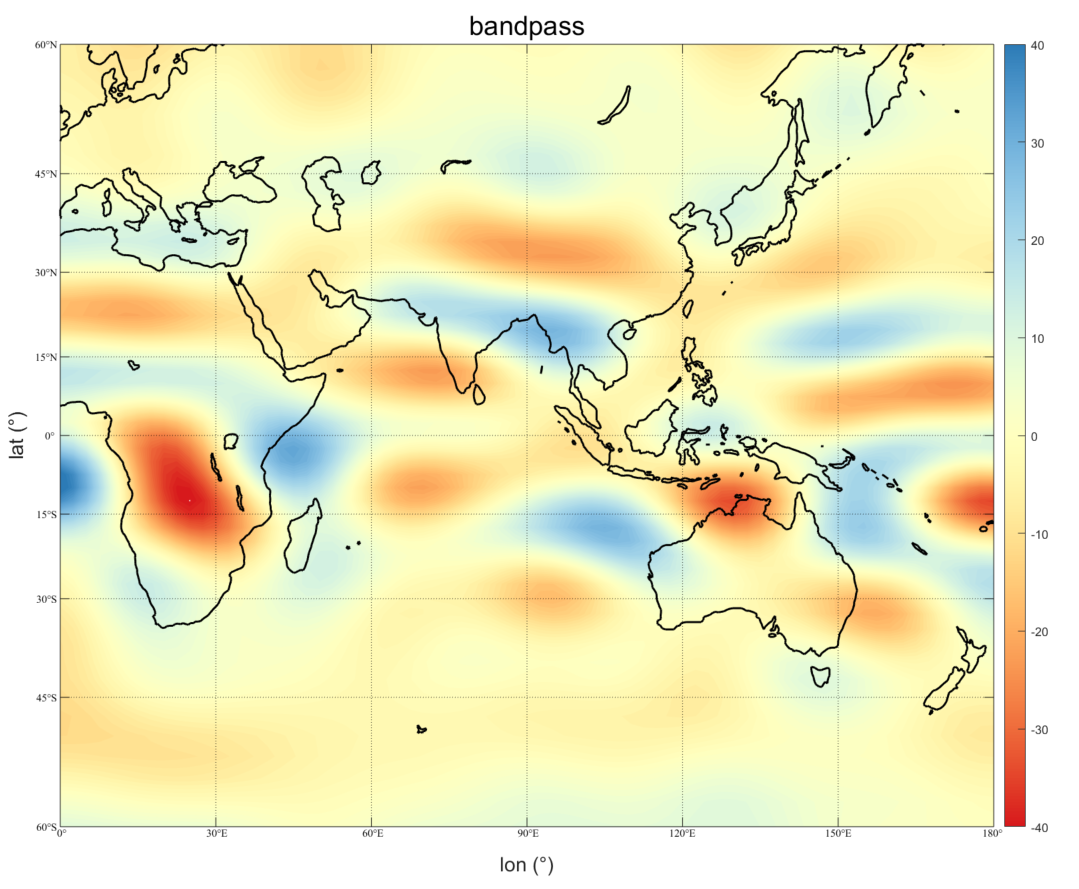


## 使用自带的matlab空间滤波函数

```matlab
clear all;

clc;

path = 'M:\old_desktop\any\daily\jxp\olr.mon.mean.nc';


%%
ncdisp(path);
lon=ncread(path,'lon');
lat=ncread(path,'lat');
olr=ncread(path,'olr');
time=ncread(path,'time');
%%
x=NaN(144,73,559);
x_low=NaN(144,73,559);
x_high=NaN(144,73,559);
lambda=[4000,2000];
for i=1:559
    x(:,:,i)=filt2(olr(:,:,i),111*2.5,lambda,'bp') ;
    x_low(:,:,i)=filt2(olr(:,:,i),111*2.5,min(lambda),'lp') ;
    x_high(:,:,i)=filt2(olr(:,:,i),111*2.5,max(lambda),'hp') ;
      
end

%%
[X,Y]=meshgrid(lon,lat);
%%
figure()
levels = -20:1:20;
subplot(1,3,1);
m_proj('mercator','long',[0 180],'lat',[-60 60]);
m_contourf(X,Y,x(:,:,559)',levels ,'edgecolor','none');
m_coast('linewidth',1.5,'color','k');
m_grid('tickdir','in','fontname','Times New Roman','fontsize',8,'xtick',[0:30:180],'ytick',[-60:15:60]);
set(gcf,'color','w');
colormap(othercolor('RdYlBu5'));
colorbar;
caxis([-20 20]);
title (' bandpass ','fontsize',20)
xlabel (' lon (°) ','fontsize',15)
ylabel (' lat (°) ','fontsize',15)


subplot(1,3,2);

m_proj('mercator','long',[0 180],'lat',[-60 60]);
m_contourf(X,Y,x_low(:,:,559)',160:4:280,'edgecolor','none');
m_coast('linewidth',1.5,'color','k');
m_grid('tickdir','in','fontname','Times New Roman','fontsize',8,'xtick',[0:30:180],'ytick',[-60:15:60]);
set(gcf,'color','w');
colormap(othercolor('RdYlBu5'));
colorbar;
caxis([160 280]);
title (' lowpass ','fontsize',20)
xlabel (' lon (°) ','fontsize',15)
ylabel (' lat (°) ','fontsize',15)

subplot(1,3,3);

m_proj('mercator','long',[0 180],'lat',[-60 60]);
m_contourf(X,Y,x_high(:,:,559)',levels,'edgecolor','none');
m_coast('linewidth',1.5,'color','k');
m_grid('tickdir','in','fontname','Times New Roman','fontsize',8,'xtick',[0:30:180],'ytick',[-60:15:60]);
set(gcf,'color','w');
colormap(othercolor('RdYlBu5'));
colorbar;
caxis([-20 20]);
title (' lowpass ','fontsize',20)
xlabel (' lon (°) ','fontsize',15)
ylabel (' lat (°) ','fontsize',15)


```


- matlab-滤波结果

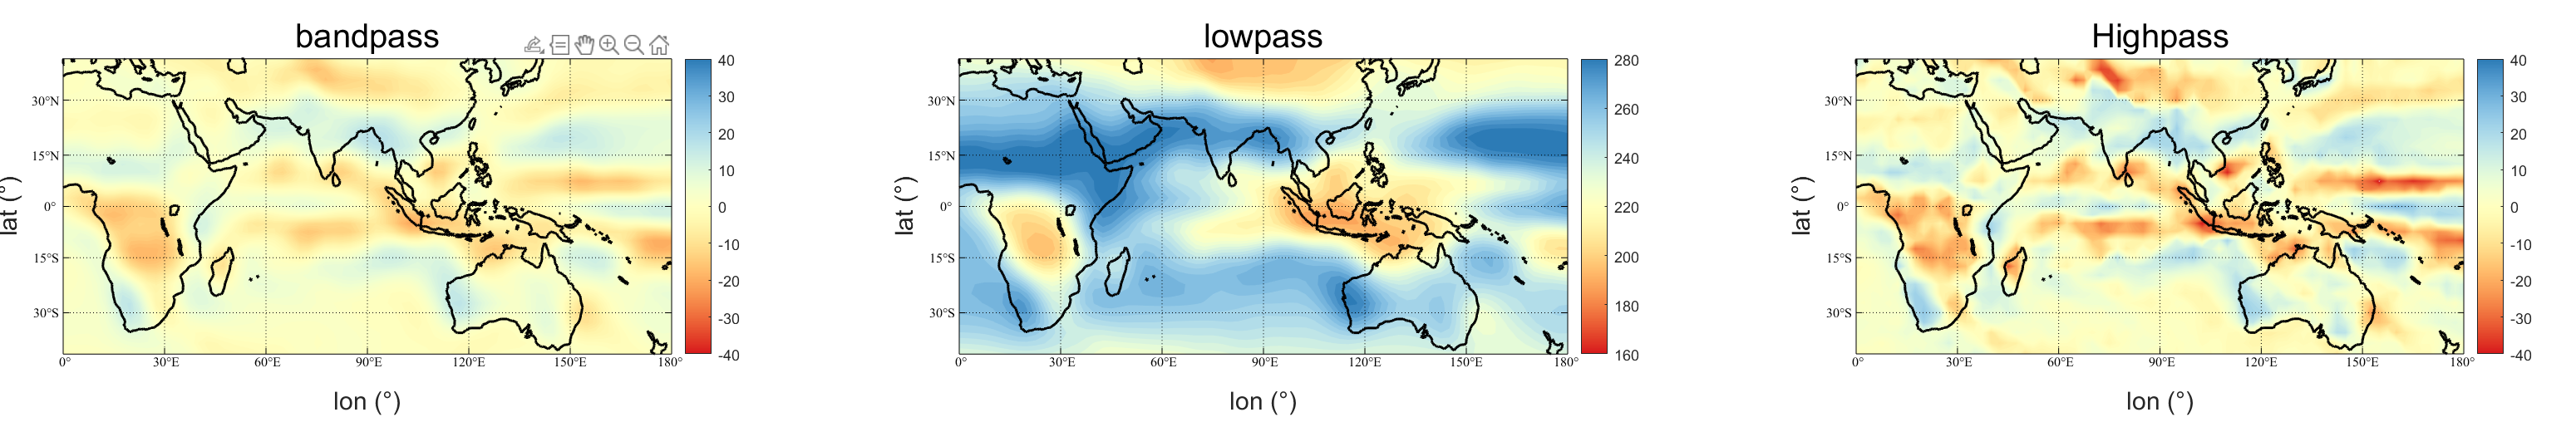

- python-滤波结果
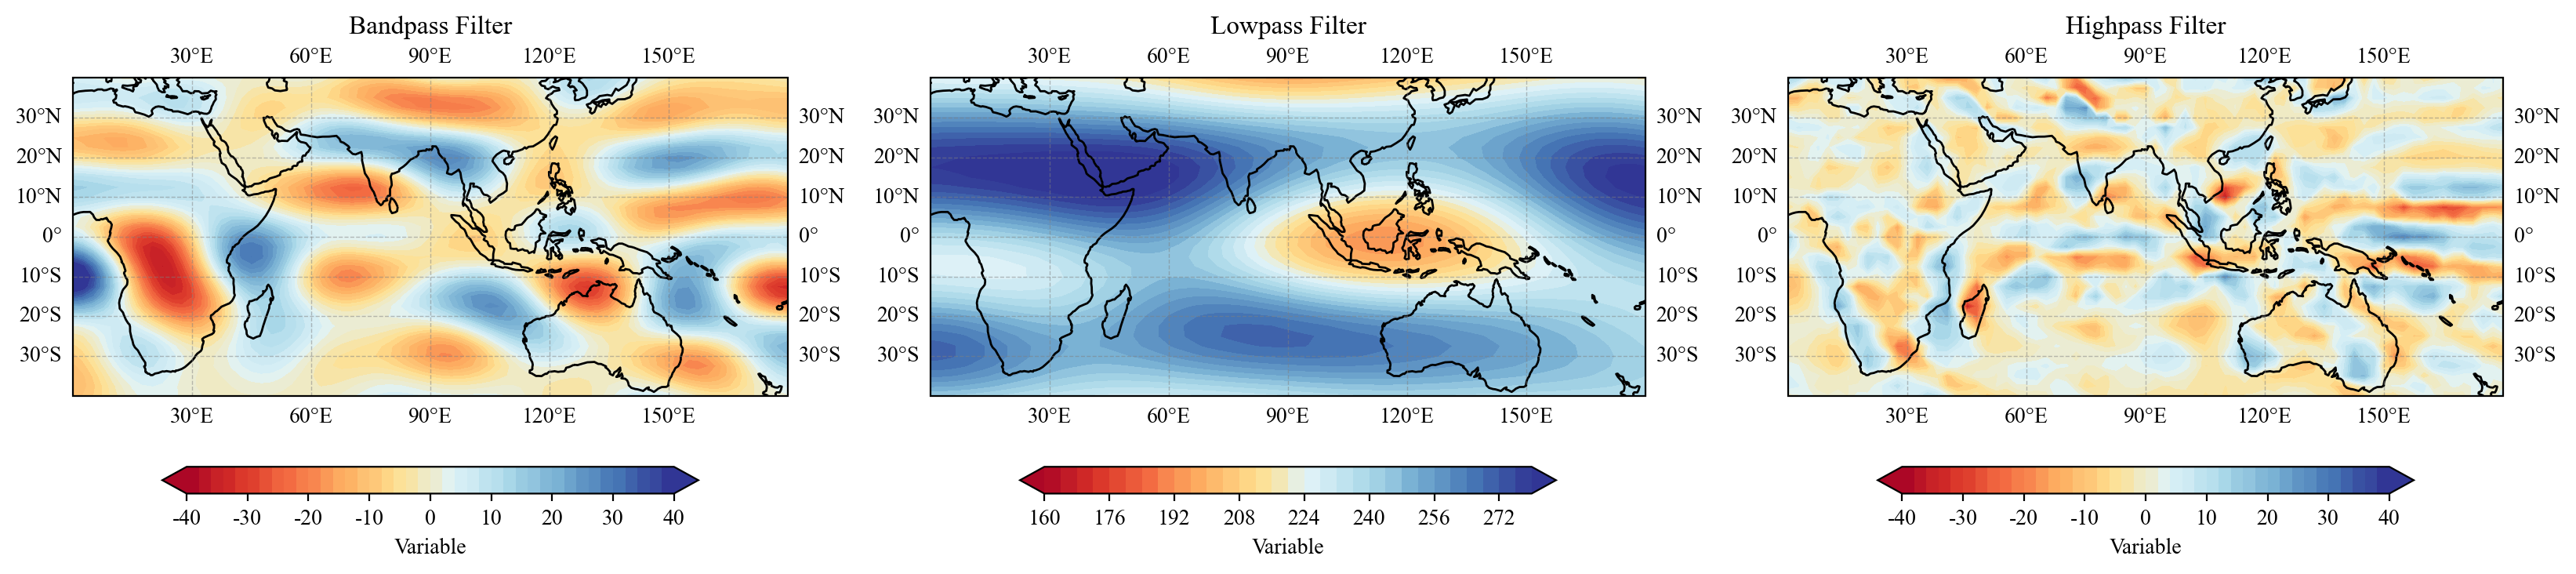
